# ATML2021 Assignment 3 Nalet Meinen

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random

import torchvision.utils as vutils

In [2]:
!nvidia-smi

Mon May 24 14:15:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   50C    P2    65W / 250W |   2458MiB / 11178MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 70%   78C    P0    90W / 250W |     10MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

Here we implement the dataset class, create the training, validation and test sets and the dataloaders.

In [3]:
class LabeledDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(LabeledDataset, self).__init__()
        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'val':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        elif self.phase == 'unlabel':
            file_path = os.path.join(folder_path, 'train_32x32_unlabel.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        if self.phase != 'test' and self.phase != 'unlabel':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        if self.phase != 'test':
            return self.transform(img_index), self.labels[index,0]
        else:
            return self.transform(img_index)

    def __len__(self):
        return self.dataset.shape[0]

In [4]:
transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ])

train_set = LabeledDataset('.', phase='train', transform=transform)
val_set = LabeledDataset('.', phase='val', transform=transform)
test_set = LabeledDataset('.', phase='test', transform=transform)
unlabel_set = LabeledDataset('.', phase='unlabel', transform=transform)

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
unlabel_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

Label: 7
Image shape: torch.Size([3, 32, 32])


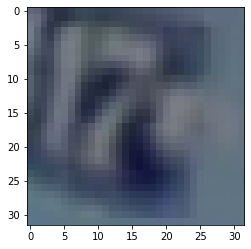

In [5]:
sample_image = train_set[0]
plt.imshow(sample_image[0].permute(1,2,0)*0.5 + 0.5)
print("Label:", sample_image[1])
print("Image shape:", sample_image[0].shape)

Let us define a fully-convolutional classifier.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer01 = nn.Sequential(
            nn.Conv2d(3, 64, 2, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer02 = nn.Sequential(
            nn.Conv2d(64, 128, 2, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer03 = nn.Sequential(
            nn.Conv2d(128, 1024, 2, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer04 = nn.Sequential(
            nn.Conv2d(1024, 128, 2, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer05 = nn.Sequential(
            nn.Conv2d(128, 1, 5, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.layer01(input)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = self.layer05(output)
        return output

class Block(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), 
                nn.BatchNorm2d(planes)
            )

    def forward(self, input):
        output = nn.functional.relu(self.bn1(self.conv1(input)))
        output = self.bn2(self.conv2(output))
        output += self.shortcut(input)
        output = nn.functional.relu(output)
        return output

class ClassifierNet(nn.Module):

    def __init__(self, num_blocks=[2, 2, 2, 2]):
        super(ClassifierNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, 10)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, input):
        output = nn.functional.relu(self.bn1(self.conv1(input)))
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = nn.functional.avg_pool2d(output, 4)
        output = torch.flatten(output, 1)
        output = self.linear(output)
        return nn.functional.log_softmax(output, dim=1)
    
print(Generator())
print(Discriminator())
print(ClassifierNet())

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = ClassifierNet().to(device)

noise = torch.randn(4, 3, 32, 32, device=device)
out = model(noise)
print("Model output shape:", out.size())

Model output shape: torch.Size([4, 10])


Define the criterion and the optimizer.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model for 20 epochs.

In [9]:
for epoch in tqdm(range(200)):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Test the model on the validation set.

In [10]:
correct = 0
total = 0
total_loss = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

print('Accuracy of the network on the 2000 validation images: %d %%' % (
    100 * correct / total))
print('Val loss', total_loss / len(val_loader))

Accuracy of the network on the 2000 validation images: 39 %
Val loss 3.776410222053528


In [ ]:
# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 128, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for i, data in enumerate(unlabel_loader):
        # maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        pbar.set_description('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                            % (i, len(unlabel_loader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        iters += 1

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
torch.save(netD.state_dict(), "unsuperviced_pre-training.pht")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
real_batch = next(iter(unlabel_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(taskname,train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

    best_model = ClassifierNet()
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch

def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

def test_pretrained(taskname,num_blocks,val_dataloader,loss_fn):
    best_model = ClassifierNet(num_blocks)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))
    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Model:", taskname, "Average loss:", m_loss, "Accuracy:", accuracy)

def show_validation_errors(taskname,num_blocks,test_loader,num_images=10):
    model = ClassifierNet(num_blocks)
    model = model.to(device)
    model.load_state_dict(torch.load(str(taskname)+".pht"))

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(_t_mean)
        std = np.array(_t_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.figure(figsize=(5,5))
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)
            
            for j in range(images.size()[0]):
                if(labels.cpu().data[j] == preds[j]):
                    continue
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('actual: {}, predicted: {}'.format(labels.cpu().data[j], preds[j]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    return

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy

In [ ]:
def get_transfer_model(): 
    #Preparations
    pretrained_model = Discriminator()
    pretrained_model = pretrained_model.to(device)
    pretrained_model.load_state_dict(torch.load("unsuperviced_pre-training.pht"))

    #Transfer
    transfer_model = ClassifierNet()
    transfer_model.layer01 = pretrained_model.layer01
    transfer_model.layer02 = pretrained_model.layer02
    transfer_model.layer03 = pretrained_model.layer03
    transfer_model.layer04 = pretrained_model.layer04
    return transfer_model

# train_dataloader = DataLoader(dataset_train_labelled, batch_size=batch_size, shuffle=True, num_workers=workers)
# val_dataloader = DataLoader(dataset_validation_labelled, batch_size=batch_size, shuffle=False, num_workers=workers)
n_epochs = 150
loss_fn = nn.CrossEntropyLoss()

In [ ]:
%%time
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

model.layer01.requires_grad = False
model.layer02.requires_grad = False
model.layer03.requires_grad = False
model.layer04.requires_grad = False

lr = 0.001

optimizer = optim.Adam(model.classifier.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("fixed_features", train_loader, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader, val_loader)

We expect similar accuracy on the leaderboard. However, the overfitting is clear. Let us prepare the submission file.

In [ ]:
predictions = np.array([])

with torch.no_grad():
    for data in test_loader:
        inputs = data
        inputs = inputs.to(device)
        
        outputs = model(inputs)
            
        _, predicted = torch.max(outputs.data, 1)
        predictions = np.append(predictions, predicted.cpu())

In [ ]:
predictions = pd.DataFrame({
    "Id": np.arange(predictions.size),
    "Category": predictions},
    dtype=np.int64)

In [ ]:
predictions.to_csv("baseline_predictions.csv", index=False)